In [1]:
import numpy as np
from copy import deepcopy
import itertools
import matplotlib
from numpy import radians as rad
from matplotlib.animation import FuncAnimation
from scipy.ndimage import convolve,convolve1d
import cmasher
import seaborn as sns
from collections import defaultdict
from manim import *
import networkx as nx
from scipy.interpolate import interp1d
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import random
from networkx.drawing.nx_pydot import graphviz_layout
from scipy.special import softmax
import itertools as it

In [2]:
import hloss_misc as _hloss

In [187]:
from collections import deque

# Softmax-margin loss

In [3]:
def create_exact_graph():
    G = nx.DiGraph()
    G.add_edges_from([
        (0, 2), (0, 1), 
        (2, 6), (2, 5), (1, 666),
        (6, 9), (5, 7), (5, 8), (666, 3), (666, 4),
        
    ])
    return G

In [4]:
G = create_exact_graph()

In [134]:
def make_graph_hloss():
    contigs = [
        '0;2;6;9',
        '0;2;5;7',
        '0;2;5;8',
        '0;1;666;3',
        '0;1;666;4',
    ]
    return _hloss.make_graph([_hloss.ContigTaxonomy.from_semicolon_sep(c, False) for c in contigs])

In [135]:
GRAPH_NODES, IND_NODES, TABLE_PARENT = make_graph_hloss()

In [109]:
hier = _hloss.Hierarchy(np.array(TABLE_PARENT))

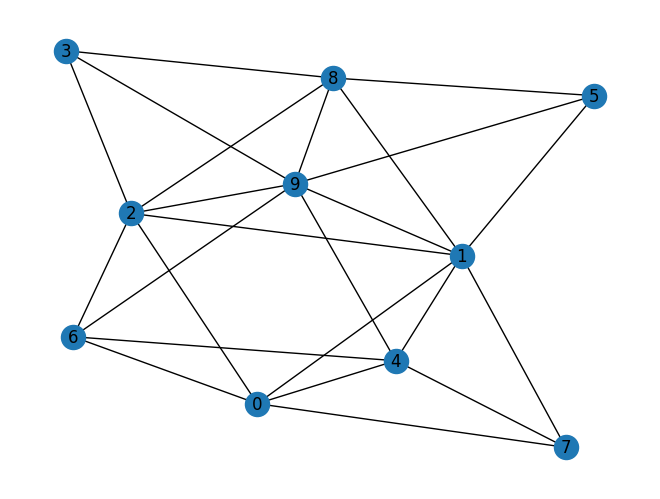

In [428]:
import networkx as nx
import random
import planarity  # Optional but recommended for planarity checks

def generate_random_planar_graph(N):
    # Start with a small cycle to seed a planar graph
    G = nx.cycle_graph(min(N, 3)) if N >= 3 else nx.path_graph(N)

    # Add edges randomly while keeping the graph planar
    while G.number_of_nodes() < N:
        G.add_node(G.number_of_nodes())

    # Randomly add edges while maintaining planarity
    possible_edges = [(u, v) for u in G.nodes() for v in G.nodes() if u < v]
    random.shuffle(possible_edges)

    for u, v in possible_edges:
        if G.number_of_edges() >= 3 * (N - 2):  # Bound for a planar graph
            break
        if not G.has_edge(u, v):
            G.add_edge(u, v)
            if not planarity.is_planar(G):
                G.remove_edge(u, v)  # Remove edge if graph is not planar

    return G



In [459]:
def assign_parents(likelihoods, children):
    par_dict = defaultdict(int)
    for n, l in zip(children, likelihoods):
        parent = list(G.predecessors(n))[0]
        par_dict[parent] += l
    return par_dict


class SoftmaxMargin(Scene):
    
    def construct(self):
        LAYOUT_CONFIG = {"vertex_spacing": (1, 1)}
        VERTEX_CONF = {"radius": 0.25, "color": BLACK, "fill_opacity": 1, "stroke_opacity": 1, "stroke_color": WHITE, "stroke_width": 2}
        
        graph = Graph(
            list(G.nodes), 
            list(G.edges), 
            layout="tree", 
            root_vertex=0, 
            layout_config=LAYOUT_CONFIG,
            vertex_config=VERTEX_CONF,
        )
        leaves = [node for node in G.nodes() if G.degree(node) == 1]
        N_leaves = len(leaves)
        
        GT = leaves[2]
        INDEX_MAP = {n: i for i, n in enumerate(G.nodes())}
        ground_truth = [GT]
        gt = GT
        for _ in range(4):
            for p in G.predecessors(gt):
                ground_truth.append(p)
                gt = p

        leaves_vertices = VGroup(*[graph[l].copy() for l in leaves])

        self.play(FadeIn(graph))
        self.wait(1)

        all_nodes = VGroup(*[graph[l].copy() for l in G.nodes()])

        all_nodes.arrange(buff=0.5)

        self.play(*[Transform(graph[l], all_nodes[i]) for i, l in enumerate(G.nodes())] + [FadeOut(graph.edges[edge]) for edge in graph.edges])

        self.wait(1)

        squares = [Square().scale(0.5).move_to(n.get_center()) for n in all_nodes]
        boxes = VGroup(*squares)

        self.play(FadeIn(boxes))
        self.wait(1)

        self.play(boxes.animate.shift(DOWN))

        cmap = cmasher.get_sub_cmap(sns.dark_palette("#9CDCEB", as_cmap=True), 0, 1)

        logits = [random.uniform(0, 1) for _ in squares]
        logit_text = Text("logits", font_size=20).next_to(boxes, RIGHT)
        # lik_text = Text("likelihoods", font_size=20).next_to(all_nodes, RIGHT)
        # arrow = CurvedArrow(start_point=logit_text.get_right(), end_point=lik_text.get_right()).shift(RIGHT*0.05)
        # softmax_text = MathTex(r"\frac{e^{l_{i}}}{\sum_{j=1}^K e^{l_{j}}}", font_size=20).move_to(arrow.get_right()).shift(RIGHT*0.6)

        color_anim = [square.animate.set_fill(RED, opacity=logits[i]) for i, square in enumerate(squares)]
        text_objs = [Text(f"{l:.2f}", font_size=30).move_to(b.get_center()) for l, b in zip(logits, boxes)] # remove later
        text_anim = [Write(t) for t in text_objs]
        self.play(*(color_anim + text_anim))
        self.play(Write(logit_text))
        self.wait(1)

        # likelihoods = softmax(logits)
        likelihoods = logits
        text_objs_softmax1 = [Text(f"{l:.2f}", font_size=15).move_to(b.get_center()) for l, b in zip(likelihoods, all_nodes)]
        text_anim_softmax = [Write(t) for t in text_objs_softmax1]

        color_anim_softmax = [graph[l].animate.set_fill(rgba_to_color(cmap(likelihoods[i]))) for i, l in enumerate(G.nodes())]
        
        # self.play(*(color_anim_softmax + text_anim_softmax + [Write(softmax_text), Write(arrow), Write(lik_text)]))
        self.play(*(color_anim_softmax + text_anim_softmax))
        self.wait(1)

        # all_texts = text_objs + [logit_text, lik_text, arrow]
        all_texts = text_objs + [logit_text]
        self.play(*[Unwrite(x) for x in all_texts] + [FadeOut(boxes)])

        self.wait(1)

        # Transform nodes and text back to their original graph layout
        original_layout = graph._layout
        labels = text_objs_softmax1

        # Animate nodes and their labels back to their original positions
        for i, l in enumerate(G.nodes()):
            graph[l].generate_target()
            graph[l].target.move_to(original_layout[l])
            labels[i].generate_target()
            labels[i].target.move_to(graph[l].target.get_center())
        
        self.play(
            *[MoveToTarget(graph[l]) for l in G.nodes()],
            *[MoveToTarget(labels[i]) for i, l in enumerate(G.nodes())],
            run_time=2,
            rate_func=smooth
        )
        self.play(*[FadeIn(graph.edges[edge]) for edge in graph.edges])
        
        self.wait(1)

        SCALE_COEF = 0.5

        def get_new_position(obj, SCALE_COEF):
            return obj.get_center() * SCALE_COEF + UP * 2 + RIGHT * 5
        
        def scale_and_move_graph(graph, G, labels, SCALE_COEF, new_position_func):
            anims = []
        
            # Move and scale each node, its label, and its edges
            for i, l in enumerate(G.nodes()):
                # Calculate the new position for the node
                new_position = new_position_func(graph[l], SCALE_COEF)
                node_anim = graph[l].animate.scale(SCALE_COEF).move_to(new_position)
                
                # Move the label to the new position of the node
                label_anim = labels[i].animate.scale(SCALE_COEF).move_to(new_position)
                
                # Append the animations for the node and label
                anims.append(node_anim)
                anims.append(label_anim)
            
            # Move the edges as well
            for edge in graph.edges:
                start_pos = new_position_func(graph[edge[0]], SCALE_COEF)
                end_pos = new_position_func(graph[edge[1]], SCALE_COEF)
            
                # Animate the edge movement along with the nodes
                edge_anim = graph.edges[edge].animate.put_start_and_end_on(start_pos, end_pos)
                anims.append(edge_anim)
            return anims

        anims = scale_and_move_graph(graph, G, labels, SCALE_COEF, get_new_position)
        # Play all animations (nodes, labels, and edges) together
        self.play(*anims)
        self.wait(1)

        # text_loss = Text("Loss", font_size=40).next_to(graph, UP)
        # text_1 = Text("1.", font_size=40).next_to(graph, LEFT)
        # text_2 = Text("2.", font_size=40).next_to(text_1, DOWN*6)
        # text_q = Text("?", font_size=40).next_to(text_2, RIGHT)

        # self.play(*[Write(t) for t in (text_loss, text_1)])
        # self.wait(1)

        # self.play(Write(text_2))
        # self.play(Write(text_q))
        # self.wait(1)

        G_copy = G.to_undirected()

        graph_margin = Graph(
            list(G_copy.nodes), 
            list(G_copy.edges), 
            layout="tree", 
            root_vertex=0, 
            layout_config=LAYOUT_CONFIG,
            vertex_config=VERTEX_CONF,
        )
        self.add_foreground_mobjects(*labels)
        for label in labels:
            label.save_state()
        # self.play(*[Unwrite(t) for t in [text_loss, text_1, text_2, text_q] + labels] + [FadeOut(graph), FadeIn(graph_margin)])
        self.play(*[Unwrite(t) for t in labels] + [FadeOut(graph), FadeIn(graph_margin)])
        self.wait(1)

        NEW_GT = 5
        new_gt = graph_margin[NEW_GT]
        surbox = SurroundingRectangle(new_gt, color=YELLOW)

        self.play(FadeIn(surbox))
        self.wait(1)

        distances = {node: None for node in G_copy.nodes}  # Initialize distances as None
        distances[NEW_GT] = 0  # Distance to the start node is 0

        # Create a dictionary of labels for each node to display distances
        labels_margin = {node: Text("", font_size=30).move_to(graph_margin[node].get_center()) for node in G_copy.nodes()}
        labels_margin[NEW_GT].become(Text("0", font_size=30).move_to(graph_margin[NEW_GT].get_center()))  # Set start distance

        # Add labels to the scene
        self.play(*[FadeIn(label) for label in labels_margin.values()])
        self.wait(1)

        # BFS traversal from the NEW_GT node
        queue = deque([NEW_GT])
        visited = set([NEW_GT])

        cmap = cmasher.get_sub_cmap(sns.dark_palette("#FC6255", as_cmap=True), 0, 1)

        texts = [labels_margin[NEW_GT]]

        while queue:
            current = queue.popleft()
            current_distance = distances[current]

            # Visit each neighbor, including parents and children
            for neighbor in G_copy.neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    distances[neighbor] = current_distance + 1
                    
                    # Animate the path to the neighbor
                    try:
                        edge_anim = Create(graph_margin.edges[(current, neighbor)])
                    except KeyError:
                        edge_anim = Create(graph_margin.edges[(neighbor, current)])
                    
                    # Update the distance label on the neighbor node
                    t = Text(str(distances[neighbor]), font_size=30).move_to(graph_margin[neighbor].get_center())
                    texts.append(t)
                    color_anim_margin = graph_margin[neighbor].animate.set_fill(rgba_to_color(cmap(distances[neighbor] / 5)))
                    
                    # Play the animations
                    self.play(color_anim_margin, Write(t), run_time=0.5)

        self.wait(1)

        reverse_colors = [graph_margin[l].animate.set_fill(BLACK) for i, l in enumerate(G_copy.nodes())]

        self.play(*(reverse_colors + [Unwrite(t) for t in texts]))
        
        self.wait(1)

        def info_dist_eqs():
            SHIFT_LEFT = LEFT*6.5
    
            eq_pt = [
                r"p - predicted, t - truth",
            ]
            pt = MathTex(*eq_pt, font_size=30).align_to(SHIFT_LEFT, LEFT).shift(UP*3.5)
    
            eq_lca = [
                r"lca(p, t) - last\ common\ ancestor",
            ]
            lca = MathTex(*eq_lca, font_size=30).align_to(SHIFT_LEFT, LEFT).shift(UP*3)
    
            eq_c = [
                r"C(p) - number\ of\ descendant\ leaves",
            ]
            count = MathTex(*eq_c, font_size=30).align_to(SHIFT_LEFT, LEFT).shift(UP*2.5)
    
            eq = [
                r"margin(p, t) = log(\frac{C(lca(p, t))}{C(p)C(t)})",
            ]
            nll_coef = MathTex(*eq, font_size=35).align_to(SHIFT_LEFT, LEFT).shift(UP*1.5)
            return [pt, lca, count, nll_coef]

        def incorrect_eqs():
            SHIFT_LEFT = LEFT*6.5
    
            eq_pt = [
                r"margin(p, t) = \begin{cases} 0\ if\ predicted\ is\ an\ ancestor\ of\ truth \\ 1\ otherwise \end{cases}",
            ]
            nll_coef = MathTex(*eq_pt, font_size=35).align_to(SHIFT_LEFT, LEFT).shift(UP*3)
            
            return [nll_coef]

        def distance_eqs():
            return []

        def play_margins(margin_type, text_fun, text_size, eqs_func, erase_after=True):
            loss_fn = _hloss.MarginLoss(
                    hier,
                    with_leaf_targets=False,
                    hardness="soft",
                    margin=margin_type,
                    tau=0.01,
            )
    
            margins = np.array(loss_fn.margin[INDEX_MAP[NEW_GT] + 1])
            margins_norm = margins / np.max(margins)
    
            cmap = cmasher.get_sub_cmap(sns.dark_palette("#FC6255", as_cmap=True), 0, 1)
            color_anim_margin = [graph_margin[l].animate.set_fill(rgba_to_color(cmap(margins_norm[INDEX_MAP[l] + 1]))) for i, l in enumerate(G.nodes())]
            text_objs_margin = [Text(text_fun(margins[INDEX_MAP[l] + 1]), font_size=text_size).move_to(graph_margin[l].get_center())
                                for i, l in enumerate(G.nodes())]
            text_anim_margin = [Write(t) for t in text_objs_margin]
            eqs = eqs_func()
            eqs_anims = [FadeIn(e) for e in eqs]
            self.play(*(color_anim_margin + text_anim_margin + eqs_anims))
            self.wait(2)
            if erase_after:
                reverse_colors = [graph_margin[l].animate.set_fill(BLACK) for i, l in enumerate(G_copy.nodes())]
                self.play(*(reverse_colors + [Unwrite(t) for t in text_objs_margin] + [FadeOut(e) for e in eqs]))
                self.wait(1)
            return text_objs_margin

        for mt, ft, fs, es, ea in zip(['depth_dist', 'info_dist', 'incorrect'][::-1], 
                          [lambda t: f"{int(t)}", lambda t: f"{t:.1f}", lambda t: f"{int(t)}"][::-1],
                          [30, 20, 30][::-1],
                          [distance_eqs, info_dist_eqs, incorrect_eqs][::-1],
                          [False, True, True][::-1],
                        ):
            current_margin_labels = play_margins(mt, ft, fs, es, erase_after=ea)

        def get_new_position_margin(obj, SCALE_COEF):
            return obj.get_center() * SCALE_COEF + RIGHT * 5 + DOWN

        # Trying to find values of p_i that will bring _the total sum_ to the smallest value
        # Which means that the values with big margins will be punished more

        self.play(FadeOut(surbox))
        
        anims = scale_and_move_graph(graph_margin, G_copy, current_margin_labels, 0.5, get_new_position_margin)

        text_1 = Text("logits", font_size=30).next_to(graph, UP)
        text_2 = Text("margins", font_size=30).next_to(graph, DOWN*2.2 )
        
        all_nodes = VGroup(*[graph[l].copy() for l in G.nodes()])
        text_objs_softmax1 = [Text(f"{l:.2f}", font_size=7.5).move_to(b.get_center()) for l, b in zip(likelihoods, all_nodes)]
        
        self.play(*[Write(t) for t in [text_1, text_2]] + [FadeIn(graph)] + anims)
        
        self.play(*[Write(t) for t in text_objs_softmax1])
        

        surbox = SurroundingRectangle(graph[NEW_GT], color=YELLOW)
        self.play(FadeIn(surbox))

        self.wait(1)
        
        formula = MathTex(
            r"\mathcal{L} = -\log p_{gt} + \log \sum_{\mathbf{u} \in graph} e^{s_{u} + \tau \cdot \text{margin}(u, gt)}",
            font_size=50
        )
        formula.move_to(LEFT*2)

        # Display the formula
        self.play(Write(formula))
        self.wait(1)

        first_term = formula[0][2:9]  # This selects "-log p_{gt}"
        self.play(first_term.animate.set_color(BLUE)) 
        self.wait(1)

        # You might recognise logsumexp function from when it's used to perform certain calculations that require numerical stability.
        # However, here we use it as a smooth approximation of a maximum. 
        # Long story short, by minimizing this term, we in principle push all the likelihoods down
        # but those that have larger margin, will be penalised harder and thus, go down faster.
        # So, how we choose to set up the margin, will determine how the output structure is enforced.
        # And the little tau term is just here for scaling the margin, since it might have very different range of values.

        p_gt_node = graph[NEW_GT].copy()
        gt_box = VGroup(surbox.copy(), p_gt_node)

        p_term = formula[0][6:9]
        self.play(gt_box.animate.next_to(p_term, UP))
        
        self.wait(1)

        p_term_all = formula[0][22:24]
        p_margin_all = formula[0][32:33]

        p_term_logsumexp = formula[0][10:22]
        br = Brace(p_term_logsumexp, direction=DOWN).set_color(GREEN)
        text_logsumexp = Text('"logsumexp"', font_size=30).next_to(br, DOWN).set_color(GREEN)
        
        self.play(Write(text_logsumexp), Write(br), p_term_logsumexp.animate.set_color(GREEN))

        nodes = []
        
        for n in G.nodes():
            g, gm = graph[n].copy(), graph_margin[n].copy()
            self.play(g.animate.next_to(p_term_all, UP), gm.animate.next_to(p_margin_all, UP))
            nodes.extend([g, gm])

        self.wait(1)

        tau_term = formula[0][25]
        self.play(tau_term.animate.set_color(YELLOW))

        self.wait(1)

        self.play(FadeOut(formula), FadeOut(gt_box), Unwrite(br), Unwrite(text_logsumexp), *[FadeOut(n) for n in nodes])

        # self.play(FadeOut(surbox), FadeOut(text_1), FadeOut(text_2), *(anims_graph + anims_margin))
        self.play(FadeOut(graph), FadeOut(graph_margin), FadeOut(surbox), FadeOut(text_1), FadeOut(text_2), *[Unwrite(t) for t in text_objs_softmax1 + current_margin_labels])

        # Example usage
        N = len(G.nodes())  # Number of nodes
        planar_graph = generate_random_planar_graph(N)

        graph_random = Graph(
            list(planar_graph.nodes), 
            list(planar_graph.edges), 
            layout="spring", 
            layout_config={},
            vertex_config=VERTEX_CONF,
        )

        NEW_GT = 3

        self.play(FadeIn(graph_random))
        distances = {node: None for node in planar_graph.nodes}  # Initialize distances as None
        distances[NEW_GT] = 0  # Distance to the start node is 0
        # BFS traversal from the NEW_GT node
        queue = deque([NEW_GT])
        visited = set([NEW_GT])

        cmap = cmasher.get_sub_cmap(sns.dark_palette("#FC6255", as_cmap=True), 0, 1)
        
        labels_margin = {node: Text("", font_size=30).move_to(graph_random[node].get_center()) for node in planar_graph.nodes()}
        labels_margin[NEW_GT].become(Text("0", font_size=30).move_to(graph_random[NEW_GT].get_center()))  # Set start distance

        self.play(*[FadeIn(label) for label in labels_margin.values()])
        self.wait(1)
        
        texts = [labels_margin[NEW_GT]]

        while queue:
            current = queue.popleft()
            current_distance = distances[current]

            # Visit each neighbor, including parents and children
            for neighbor in planar_graph.neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)
                    distances[neighbor] = current_distance + 1
                    
                    # Animate the path to the neighbor
                    try:
                        edge_anim = Create(graph_random.edges[(current, neighbor)])
                    except KeyError:
                        edge_anim = Create(graph_random.edges[(neighbor, current)])
                    
                    # Update the distance label on the neighbor node
                    t = Text(str(distances[neighbor]), font_size=30).move_to(graph_random[neighbor].get_center())
                    texts.append(t)
                    color_anim_margin = graph_random[neighbor].animate.set_fill(rgba_to_color(cmap(distances[neighbor] / 5)))
                    
                    # Play the animations
                    self.play(color_anim_margin, Write(t), run_time=0.25)

        self.wait(1)

In [460]:
%manim SoftmaxMargin

Manim Community v0.18.1

[10/28/24 22:31:20] INFO     Animation 0 : Using cached data (hash :                           ]8;id=481898;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=56713;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             3977891868_1413458727_223132457)                                                      

                    INFO     Animation 1 : Using cached data (hash :                           ]8;id=202232;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=881626;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_1992872043)                                                     

                    INFO     Animation 2 : Using cached data (hash :                           ]8;id=783624;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=332094;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_4035195194_2355393394)                                                     

                    INFO     Animation 3 : Using cached data (hash :                           ]8;id=403954;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=919421;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_2122705886)                                                     

[10/28/24 22:31:21] INFO     Animation 4 : Using cached data (hash :                           ]8;id=696721;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=353024;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2629710179_2501444668)                                                     

                    INFO     Animation 5 : Using cached data (hash :                           ]8;id=219883;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=49186;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_3246010116)                                                     

                    INFO     Animation 6 : Using cached data (hash :                           ]8;id=377618;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=256839;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_1179880774_23409678)                                                       

[10/28/24 22:31:23] INFO     Animation 7 : Partial movie file written in                   ]8;id=178773;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=203141;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             271720859_148247676.mp4'                                                              

[10/28/24 22:31:24] INFO     Animation 8 : Partial movie file written in                   ]8;id=527741;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=997811;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             507398208_1970687959.mp4'                                                             

[10/28/24 22:31:25] INFO     Animation 9 : Partial movie file written in                   ]8;id=675417;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=587601;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_1603362246.mp4'                                                            

[10/28/24 22:31:27] INFO     Animation 10 : Partial movie file written in                  ]8;id=539655;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=824595;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1412481588_603031928.mp4'                                                             

[10/28/24 22:31:28] INFO     Animation 11 : Partial movie file written in                  ]8;id=430305;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=86442;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_1377612573.mp4'                                                            

[10/28/24 22:31:30] INFO     Animation 12 : Partial movie file written in                  ]8;id=178934;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=491230;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3903338234_267581708.mp4'                                                             

[10/28/24 22:31:31] INFO     Animation 13 : Partial movie file written in                  ]8;id=407595;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=668706;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_2264590503.mp4'                                                            

[10/28/24 22:31:33] INFO     Animation 14 : Partial movie file written in                  ]8;id=859143;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=572512;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             4059921835_4264361933.mp4'                                                            

[10/28/24 22:31:35] INFO     Animation 15 : Partial movie file written in                  ]8;id=123565;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=999591;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3502178733_97120444.mp4'                                                              

[10/28/24 22:31:36] INFO     Animation 16 : Partial movie file written in                  ]8;id=630279;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=300693;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_1491380915.mp4'                                                            

[10/28/24 22:31:37] INFO     Animation 17 : Partial movie file written in                  ]8;id=284626;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=443182;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3049462948_3500601273.mp4'                                                            

[10/28/24 22:31:38] INFO     Animation 18 : Partial movie file written in                  ]8;id=493944;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=203320;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_3375977260.mp4'                                                            

[10/28/24 22:31:42] INFO     Animation 19 : Partial movie file written in                  ]8;id=627234;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=837728;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             740226351_677827679.mp4'                                                              

[10/28/24 22:31:43] INFO     Animation 20 : Partial movie file written in                  ]8;id=911216;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=458222;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2268332985_1123168903.mp4'                                                            

                    INFO     Animation 21 : Using cached data (hash :                          ]8;id=36295;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=787160;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_1421991312_1689037966)                                                     

                    INFO     Animation 22 : Using cached data (hash :                          ]8;id=323847;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=390460;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_2349115209)                                                     

                    INFO     Animation 23 : Using cached data (hash :                          ]8;id=946427;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=247127;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_1328744886_3073220850)                                                     

                    INFO     Animation 24 : Using cached data (hash :                          ]8;id=568785;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=152993;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_2196838835)                                                     

                    INFO     Animation 25 : Using cached data (hash :                          ]8;id=941521;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=879970;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_3601138319_1653218197)                                                     

                    INFO     Animation 26 : Using cached data (hash :                          ]8;id=179679;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=712961;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2933166538_1815098909)                                                     

[10/28/24 22:31:44] INFO     Animation 27 : Partial movie file written in                  ]8;id=670121;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=728880;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2734734555_3514897511.mp4'                                                            

                    INFO     Animation 28 : Using cached data (hash :                          ]8;id=836388;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=505022;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2857189056_3438792917)                                                     

                    INFO     Animation 29 : Using cached data (hash :                          ]8;id=911479;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=173702;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_28925366_3607319093)                                                       

                    INFO     Animation 30 : Using cached data (hash :                          ]8;id=878792;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=838788;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2642413771_4233695726)                                                     

                    INFO     Animation 31 : Using cached data (hash :                          ]8;id=509572;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=709998;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_815388963_261788858)                                                       

                    INFO     Animation 32 : Using cached data (hash :                          ]8;id=932781;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=770973;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_3500259534_1687549831)                                                     

[10/28/24 22:31:45] INFO     Animation 33 : Partial movie file written in                  ]8;id=532090;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=187618;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2571177990_199899208.mp4'                                                             

                    INFO     Animation 34 : Using cached data (hash :                          ]8;id=326873;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=598641;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_3989463776_2710716420)                                                     

                    INFO     Animation 35 : Using cached data (hash :                          ]8;id=922890;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=303070;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_989196112)                                                      

                    INFO     Animation 36 : Using cached data (hash :                          ]8;id=978147;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=906572;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_4237925025_1605490944)                                                     

[10/28/24 22:31:46] INFO     Animation 37 : Partial movie file written in                  ]8;id=813472;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=558947;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_4050601936.mp4'                                                            

[10/28/24 22:31:47] INFO     Animation 38 : Using cached data (hash :                          ]8;id=366573;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=547250;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_3208962682_1852376454)                                                     

                    INFO     Animation 39 : Using cached data (hash :                          ]8;id=631387;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=611964;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_784179552_3081198815)                                                      

                    INFO     Animation 40 : Using cached data (hash :                          ]8;id=626134;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=45103;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_3757588350_982767219)                                                      

                    INFO     Animation 41 : Using cached data (hash :                          ]8;id=937935;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=965721;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2919340033_1920033923)                                                     

[10/28/24 22:31:48] INFO     Animation 42 : Using cached data (hash :                          ]8;id=652471;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=611798;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_1601023428_147279102)                                                      

[10/28/24 22:31:49] INFO     Animation 43 : Using cached data (hash :                          ]8;id=48117;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=814514;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_784179552_1397874983)                                                      

                    INFO     Animation 44 : Using cached data (hash :                          ]8;id=981895;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=811044;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_1867019433_2416901263)                                                     

[10/28/24 22:31:50] INFO     Animation 45 : Partial movie file written in                  ]8;id=740763;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=177835;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_784683927.mp4'                                                             

                    INFO     Animation 46 : Using cached data (hash :                          ]8;id=104246;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=454802;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_4155164207_2670620055)                                                     

[10/28/24 22:31:51] INFO     Animation 47 : Using cached data (hash :                          ]8;id=6330;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=323260;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_784179552_3523675871)                                                      

                    INFO     Animation 48 : Using cached data (hash :                          ]8;id=376952;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=824750;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/renderer/cairo_renderer.py#88\88]8;;\
                             2852726489_2130259055_2929964835)                                                     

[10/28/24 22:31:53] INFO     Animation 49 : Partial movie file written in                  ]8;id=762523;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=642561;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             4005240349_2088799548.mp4'                                                            

[10/28/24 22:31:55] INFO     Animation 50 : Partial movie file written in                  ]8;id=519840;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=118070;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2690204541_1373878065.mp4'                                                            

[10/28/24 22:31:57] INFO     Animation 51 : Partial movie file written in                  ]8;id=155940;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=771465;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2668195047_161438822.mp4'                                                             

[10/28/24 22:31:58] INFO     Animation 52 : Partial movie file written in                  ]8;id=183424;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=195478;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_15180340.mp4'                                                              

[10/28/24 22:32:02] INFO     Animation 53 : Partial movie file written in                  ]8;id=689690;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=871686;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2485055379_3818736309.mp4'                                                            

[10/28/24 22:32:03] INFO     Animation 54 : Partial movie file written in                  ]8;id=291653;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=49330;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_3377466264.mp4'                                                            

[10/28/24 22:32:05] INFO     Animation 55 : Partial movie file written in                  ]8;id=663326;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=10433;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1280431189_3954718366.mp4'                                                            

[10/28/24 22:32:07] INFO     Animation 56 : Partial movie file written in                  ]8;id=674960;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=373282;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_2645613513.mp4'                                                            

[10/28/24 22:32:09] INFO     Animation 57 : Partial movie file written in                  ]8;id=677540;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=695079;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             248270307_3132745518.mp4'                                                             

[10/28/24 22:32:10] INFO     Animation 58 : Partial movie file written in                  ]8;id=375385;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=295389;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_2981891170.mp4'                                                            

[10/28/24 22:32:13] INFO     Animation 59 : Partial movie file written in                  ]8;id=120705;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=713712;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3572257427_477377859.mp4'                                                             

[10/28/24 22:32:15] INFO     Animation 60 : Partial movie file written in                  ]8;id=836864;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=96229;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2501263214_1270505277.mp4'                                                            

[10/28/24 22:32:18] INFO     Animation 61 : Partial movie file written in                  ]8;id=828519;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=266649;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3213654958_1076277628.mp4'                                                            

[10/28/24 22:32:20] INFO     Animation 62 : Partial movie file written in                  ]8;id=490150;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=715779;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2195724071_4066723774.mp4'                                                            

[10/28/24 22:32:22] INFO     Animation 63 : Partial movie file written in                  ]8;id=50146;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=173417;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3342485933_2496184673.mp4'                                                            

[10/28/24 22:32:25] INFO     Animation 64 : Partial movie file written in                  ]8;id=101076;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=161357;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2260397102_3945866905.mp4'                                                            

[10/28/24 22:32:27] INFO     Animation 65 : Partial movie file written in                  ]8;id=493283;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=606717;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3291178482_411549014.mp4'                                                             

[10/28/24 22:32:30] INFO     Animation 66 : Partial movie file written in                  ]8;id=822781;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=65078;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1702811665_4169826770.mp4'                                                            

[10/28/24 22:32:32] INFO     Animation 67 : Partial movie file written in                  ]8;id=934952;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=812080;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1952921780_2256272067.mp4'                                                            

[10/28/24 22:32:35] INFO     Animation 68 : Partial movie file written in                  ]8;id=668094;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=240341;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             4056446464_1981606376.mp4'                                                            

[10/28/24 22:32:37] INFO     Animation 69 : Partial movie file written in                  ]8;id=67234;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=918732;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             715671205_2187022678.mp4'                                                             

[10/28/24 22:32:40] INFO     Animation 70 : Partial movie file written in                  ]8;id=321720;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=576491;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1889146855_1012911615.mp4'                                                            

[10/28/24 22:32:41] INFO     Animation 71 : Partial movie file written in                  ]8;id=601008;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=563161;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_4196854677.mp4'                                                            

[10/28/24 22:32:44] INFO     Animation 72 : Partial movie file written in                  ]8;id=749428;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=608900;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             704862025_114492348.mp4'                                                              

[10/28/24 22:32:45] INFO     Animation 73 : Partial movie file written in                  ]8;id=856459;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=740467;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_114303722.mp4'                                                             

[10/28/24 22:32:48] INFO     Animation 74 : Partial movie file written in                  ]8;id=444551;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=966830;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1077121846_3710693114.mp4'                                                            

[10/28/24 22:32:51] INFO     Animation 75 : Partial movie file written in                  ]8;id=242566;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=493080;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3257158780_2790759663.mp4'                                                            

[10/28/24 22:32:53] INFO     Animation 76 : Partial movie file written in                  ]8;id=185648;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=510721;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2883163297_2397950137.mp4'                                                            

[10/28/24 22:32:54] INFO     Animation 77 : Partial movie file written in                  ]8;id=814183;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=257683;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3810289106_3308157720.mp4'                                                            

[10/28/24 22:32:55] INFO     Animation 78 : Partial movie file written in                  ]8;id=433587;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=375423;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_1302360512.mp4'                                                            

                    INFO     Animation 79 : Partial movie file written in                  ]8;id=496082;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=643472;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3547257609_3734796264.mp4'                                                            

[10/28/24 22:32:56] INFO     Animation 80 : Partial movie file written in                  ]8;id=212315;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=732943;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             188516425_1452734512.mp4'                                                             

                    INFO     Animation 81 : Partial movie file written in                  ]8;id=575362;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=259208;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             234488160_859738927.mp4'                                                              

[10/28/24 22:32:57] INFO     Animation 82 : Partial movie file written in                  ]8;id=419144;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=870237;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3598875254_2933484933.mp4'                                                            

                    INFO     Animation 83 : Partial movie file written in                  ]8;id=200850;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=838005;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             504191067_654381439.mp4'                                                              

[10/28/24 22:32:58] INFO     Animation 84 : Partial movie file written in                  ]8;id=467997;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=191856;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2337276481_40053119.mp4'                                                              

                    INFO     Animation 85 : Partial movie file written in                  ]8;id=522456;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=579490;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             3429829405_2692587988.mp4'                                                            

                    INFO     Animation 86 : Partial movie file written in                  ]8;id=517353;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=880656;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             727183351_189285501.mp4'                                                              

[10/28/24 22:32:59] INFO     Animation 87 : Partial movie file written in                  ]8;id=746931;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=679672;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             909761241_557214408.mp4'                                                              

                    INFO     Animation 88 : Partial movie file written in                  ]8;id=144128;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=601710;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             1690764319_2701505566.mp4'                                                            

[10/28/24 22:33:00] INFO     Animation 89 : Partial movie file written in                  ]8;id=110556;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=799769;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#527\527]8;;\
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/partial_movie_files/SoftmaxMargin/2852726489_                         
                             2919340033_23859014.mp4'                                                              

                    INFO     Combining to Movie file.                                      ]8;id=703419;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=383781;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#617\617]8;;\

[10/28/24 22:33:01] INFO                                                                   ]8;id=770680;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=509978;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#737\737]8;;\
                             File ready at                                                                         
                             '/Users/nmb127/Documents/animations/notebooks/media/videos/no                         
                             tebooks/1080p60/SoftmaxMargin.mp4'                                                    
                                                                                                                   

                    INFO     The partial movie directory is full (> 100 files). Therefore, ]8;id=60354;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=440951;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene_file_writer.py#707\707]8;;\
                             manim has removed the 59 oldest file(s). You can change this                          
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered SoftmaxMargin                                                    ]8;id=452369;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene.py\scene.py]8;;\:]8;id=946753;file:///Users/nmb127/opt/anaconda3/envs/youtube/lib/python3.9/site-packages/manim/scene/scene.py#247\247]8;;\
                             Played 90 animations                                                                  